# Chapter 6.3.1 - Advanced use of recurrent neural networks: A temperature-forecasting problem

In [1]:
import os

In [2]:
data_dir = './data/Chapter 6.3 - Advanced use of recurrent neural networks/'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

In [3]:
# Reading the CSV file
f = open(fname)
data = f.read()
f.close()

In [4]:
# Splitting the file line by line
lines = data.split('\n')
# Splitting the line by comma
header = lines[0].split(',')
lines = lines[1:]

print(header)
print("Number of lines: " + str(len(lines)))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
Number of lines: 420551


In [5]:
import numpy as np
from tqdm import tqdm

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in tqdm(enumerate(lines)):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

420551it [00:05, 83598.34it/s]


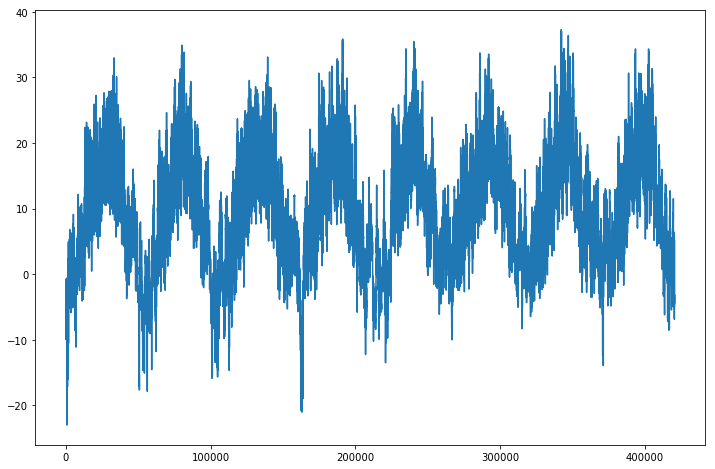

In [6]:
# Plotting the data
from matplotlib import pyplot as plt


# Temperature (in degrees Celsius)
plt.figure(figsize = (12, 8))
temp = float_data[:, 1]  
plt.plot(range(len(temp)), temp)
plt.show()

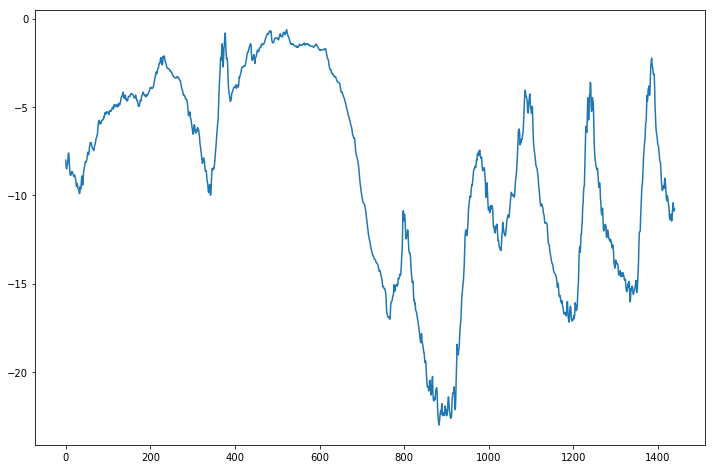

In [7]:
# The data is recorded every 10 minutes.
# Let's plot data for the first ten days.
numer_of_values_first_day = 6 * 24 * 10

plt.figure(figsize = (12, 8))

plt.plot(range(numer_of_values_first_day), temp[:numer_of_values_first_day])
plt.show()

## Preparing the data

In [8]:
# Taking first 200k datapoints and normalization.
mean = float_data[:200000].mean(axis = 0)
float_data -= mean
std = float_data[:200000].std(axis = 0)
float_data /= std

In [9]:
# Generator preparing the data
def data_preparator(data, 
                    lookback, 
                    delay, 
                    min_index, 
                    max_index,
                    shuffle = False, 
                    batch_size = 128, 
                    step = 6):
    # If the max_index is not given then use max number
    # of data points - delay - 1
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, 
                size = batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        return samples, targets

In [10]:
samples_for_analysis, targets_for_analysis = data_preparator(float_data,
                                                             lookback = 1440,
                                                             delay = 144,
                                                             min_index = 0,
                                                             max_index = 200000,
                                                             shuffle = False,
                                                             step = 1, 
                                                             batch_size = 128)

In [11]:
# Shape (batch_size, numer_of_samples, number_of_features)
samples_for_analysis.shape

(128, 1440, 14)

In [12]:
targets_for_analysis.shape

(128,)

In [13]:
samples_for_analysis[0, :, 0].shape[0]

1440

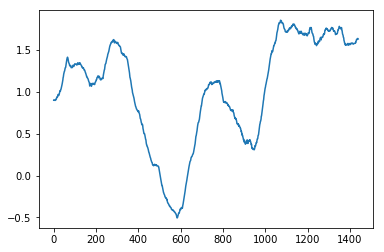

In [14]:
plt.plot(range(samples_for_analysis[0, :, 0].shape[0]), samples_for_analysis[0, :, 0])
plt.show()

In [15]:
float_data.shape

(420551, 14)

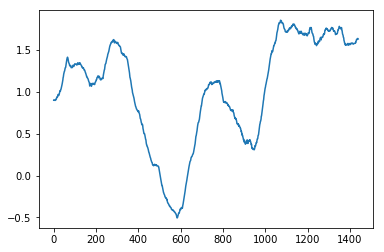

In [16]:
plt.plot(range(samples_for_analysis[0, :, 0].shape[0]), float_data[:1440, 0])
plt.show()

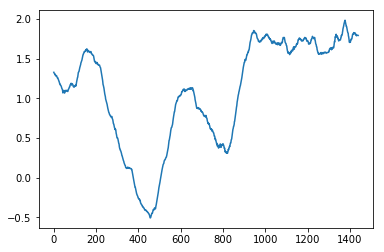

In [17]:
plt.plot(range(samples_for_analysis[127, :, 0].shape[0]), samples_for_analysis[127, :, 0])
plt.show()

In [18]:
# The data is shifted.
# The function creates a batch of sequences of shape (batch_size, number_of_samples, number_of_features).

## Machine Learning

In [19]:
# Generator preparing the data
def generator(data, 
              lookback, 
              delay, 
              min_index, 
              max_index,
              shuffle = False, 
              batch_size = 128, 
              step = 6):
    # If the max_index is not given then use max number
    # of data points - delay - 1
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, 
                size = batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [20]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

In [21]:
train_gen = generator(float_data,
                      lookback = lookback,
                      delay = delay,
                      min_index = 0,
                      max_index = 200000,
                      shuffle = True,
                      step = step, 
                      batch_size = batch_size)
val_gen = generator(float_data,
                    lookback = lookback,
                    delay = delay,
                    min_index = 200001,
                    max_index = 300000,
                    step = step,
                    batch_size = batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay = delay,
                     min_index = 300001,
                     max_index = None,
                     step = step,
                     batch_size = batch_size)

In [22]:
# Number of steps to be drawn from train_gen to see the entire training set
train_steps = (200000 - lookback) // batch_size
train_steps

1551

In [23]:
# Number of steps to be drawn from val_den to see the entire validation set
val_steps = (300000 - 200001 - lookback) // batch_size
val_steps

769

In [24]:
# Number of steps to be drawn from test_gen to see the entire test set
test_steps = (len(float_data) - 300001 - lookback) // batch_size
test_steps

930

## Naive Method

In [25]:
# Mean absolute error 
# Common-sense approach with predicting that the temperature 24 hours from now will be equal to temperature right now.
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

0.2897359729905486


## Densely connected model

In [26]:
from keras.models import Sequential
from keras.layers import Flatten, Dense
from keras.optimizers import RMSprop

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [27]:
sequence_len = lookback // step
sequence_len

240

In [28]:
number_of_features = float_data.shape[-1]
number_of_features

14

In [29]:
model = Sequential()
model.add(Flatten(input_shape = (sequence_len, number_of_features)))
model.add(Dense(units = 32, activation = 'relu'))
model.add(Dense(1))
model.compile(optimizer = RMSprop(), 
              loss = 'mae')

Explanation:

- steps_per_epoch: Total number of steps (batches of samples) to yield from generator before declaring one epoch finished and starting the next epoch. It should typically be equal to the number of samples of your dataset divided by the batch size. Optional for Sequence: if unspecified, will use the len(generator) as a number of steps.

In [30]:
history = model.fit_generator(generator = train_gen,
                              steps_per_epoch = 500,
                              epochs = 20,
                              validation_data = val_gen,
                              validation_steps = val_steps)

Epoch 1/20
500/500 [==============================] - ETA: 11:52 - loss: 1.14 - ETA: 1:44 - loss: 5.6937 - ETA: 57s - loss: 4.622 - ETA: 42s - loss: 4.13 - ETA: 37s - loss: 3.99 - ETA: 33s - loss: 3.84 - ETA: 29s - loss: 3.63 - ETA: 27s - loss: 3.55 - ETA: 25s - loss: 3.44 - ETA: 23s - loss: 3.36 - ETA: 22s - loss: 3.29 - ETA: 20s - loss: 3.18 - ETA: 20s - loss: 3.12 - ETA: 19s - loss: 3.09 - ETA: 18s - loss: 3.04 - ETA: 17s - loss: 3.00 - ETA: 17s - loss: 2.96 - ETA: 16s - loss: 2.91 - ETA: 16s - loss: 2.88 - ETA: 15s - loss: 2.85 - ETA: 14s - loss: 2.80 - ETA: 14s - loss: 2.77 - ETA: 14s - loss: 2.74 - ETA: 13s - loss: 2.71 - ETA: 13s - loss: 2.67 - ETA: 12s - loss: 2.66 - ETA: 12s - loss: 2.64 - ETA: 12s - loss: 2.62 - ETA: 12s - loss: 2.61 - ETA: 11s - loss: 2.59 - ETA: 11s - loss: 2.57 - ETA: 11s - loss: 2.56 - ETA: 11s - loss: 2.55 - ETA: 10s - loss: 2.53 - ETA: 10s - loss: 2.51 - ETA: 10s - loss: 2.49 - ETA: 10s - loss: 2.48 - ETA: 10s - loss: 2.45 - ETA: 9s - loss: 2.4449 - ETA

500/500 [==============================] - ETA: 3s - loss: 0.355 - ETA: 4s - loss: 0.393 - ETA: 4s - loss: 0.369 - ETA: 5s - loss: 0.369 - ETA: 6s - loss: 0.356 - ETA: 6s - loss: 0.362 - ETA: 6s - loss: 0.361 - ETA: 6s - loss: 0.359 - ETA: 6s - loss: 0.360 - ETA: 6s - loss: 0.356 - ETA: 6s - loss: 0.359 - ETA: 6s - loss: 0.353 - ETA: 6s - loss: 0.348 - ETA: 6s - loss: 0.351 - ETA: 6s - loss: 0.352 - ETA: 6s - loss: 0.352 - ETA: 6s - loss: 0.352 - ETA: 6s - loss: 0.352 - ETA: 6s - loss: 0.352 - ETA: 6s - loss: 0.350 - ETA: 6s - loss: 0.349 - ETA: 6s - loss: 0.349 - ETA: 6s - loss: 0.347 - ETA: 6s - loss: 0.347 - ETA: 5s - loss: 0.346 - ETA: 5s - loss: 0.345 - ETA: 5s - loss: 0.344 - ETA: 5s - loss: 0.345 - ETA: 5s - loss: 0.345 - ETA: 5s - loss: 0.345 - ETA: 5s - loss: 0.345 - ETA: 5s - loss: 0.343 - ETA: 5s - loss: 0.343 - ETA: 5s - loss: 0.343 - ETA: 5s - loss: 0.342 - ETA: 5s - loss: 0.341 - ETA: 5s - loss: 0.342 - ETA: 5s - loss: 0.341 - ETA: 5s - loss: 0.339 - ETA: 5s - loss: 0.339

500/500 [==============================] - ETA: 3s - loss: 0.257 - ETA: 4s - loss: 0.251 - ETA: 4s - loss: 0.254 - ETA: 5s - loss: 0.253 - ETA: 6s - loss: 0.256 - ETA: 6s - loss: 0.261 - ETA: 6s - loss: 0.261 - ETA: 6s - loss: 0.262 - ETA: 6s - loss: 0.261 - ETA: 6s - loss: 0.261 - ETA: 6s - loss: 0.261 - ETA: 6s - loss: 0.264 - ETA: 6s - loss: 0.263 - ETA: 6s - loss: 0.262 - ETA: 6s - loss: 0.262 - ETA: 6s - loss: 0.261 - ETA: 6s - loss: 0.261 - ETA: 6s - loss: 0.261 - ETA: 6s - loss: 0.260 - ETA: 6s - loss: 0.260 - ETA: 6s - loss: 0.261 - ETA: 6s - loss: 0.261 - ETA: 5s - loss: 0.262 - ETA: 5s - loss: 0.262 - ETA: 5s - loss: 0.261 - ETA: 5s - loss: 0.260 - ETA: 5s - loss: 0.260 - ETA: 5s - loss: 0.260 - ETA: 5s - loss: 0.260 - ETA: 5s - loss: 0.260 - ETA: 5s - loss: 0.261 - ETA: 5s - loss: 0.260 - ETA: 5s - loss: 0.259 - ETA: 5s - loss: 0.259 - ETA: 5s - loss: 0.259 - ETA: 5s - loss: 0.259 - ETA: 5s - loss: 0.259 - ETA: 5s - loss: 0.258 - ETA: 5s - loss: 0.258 - ETA: 5s - loss: 0.258

500/500 [==============================] - ETA: 4s - loss: 0.220 - ETA: 5s - loss: 0.257 - ETA: 5s - loss: 0.252 - ETA: 6s - loss: 0.252 - ETA: 7s - loss: 0.251 - ETA: 7s - loss: 0.251 - ETA: 7s - loss: 0.250 - ETA: 7s - loss: 0.249 - ETA: 7s - loss: 0.249 - ETA: 7s - loss: 0.250 - ETA: 7s - loss: 0.251 - ETA: 7s - loss: 0.249 - ETA: 7s - loss: 0.248 - ETA: 7s - loss: 0.251 - ETA: 7s - loss: 0.250 - ETA: 7s - loss: 0.251 - ETA: 7s - loss: 0.251 - ETA: 7s - loss: 0.251 - ETA: 7s - loss: 0.250 - ETA: 7s - loss: 0.249 - ETA: 7s - loss: 0.248 - ETA: 6s - loss: 0.247 - ETA: 6s - loss: 0.246 - ETA: 6s - loss: 0.246 - ETA: 6s - loss: 0.246 - ETA: 6s - loss: 0.246 - ETA: 6s - loss: 0.246 - ETA: 6s - loss: 0.245 - ETA: 6s - loss: 0.245 - ETA: 6s - loss: 0.245 - ETA: 6s - loss: 0.245 - ETA: 6s - loss: 0.245 - ETA: 6s - loss: 0.245 - ETA: 6s - loss: 0.245 - ETA: 6s - loss: 0.245 - ETA: 6s - loss: 0.245 - ETA: 6s - loss: 0.245 - ETA: 6s - loss: 0.246 - ETA: 6s - loss: 0.245 - ETA: 6s - loss: 0.245

500/500 [==============================] - ETA: 4s - loss: 0.195 - ETA: 6s - loss: 0.226 - ETA: 5s - loss: 0.229 - ETA: 6s - loss: 0.227 - ETA: 6s - loss: 0.228 - ETA: 7s - loss: 0.231 - ETA: 7s - loss: 0.231 - ETA: 7s - loss: 0.227 - ETA: 7s - loss: 0.226 - ETA: 7s - loss: 0.227 - ETA: 7s - loss: 0.230 - ETA: 7s - loss: 0.230 - ETA: 7s - loss: 0.231 - ETA: 7s - loss: 0.232 - ETA: 7s - loss: 0.231 - ETA: 7s - loss: 0.230 - ETA: 7s - loss: 0.230 - ETA: 7s - loss: 0.230 - ETA: 7s - loss: 0.231 - ETA: 7s - loss: 0.231 - ETA: 7s - loss: 0.232 - ETA: 7s - loss: 0.233 - ETA: 7s - loss: 0.234 - ETA: 7s - loss: 0.232 - ETA: 7s - loss: 0.232 - ETA: 7s - loss: 0.231 - ETA: 7s - loss: 0.231 - ETA: 6s - loss: 0.231 - ETA: 6s - loss: 0.231 - ETA: 6s - loss: 0.230 - ETA: 6s - loss: 0.231 - ETA: 6s - loss: 0.231 - ETA: 6s - loss: 0.230 - ETA: 6s - loss: 0.231 - ETA: 6s - loss: 0.231 - ETA: 6s - loss: 0.231 - ETA: 6s - loss: 0.231 - ETA: 6s - loss: 0.230 - ETA: 6s - loss: 0.231 - ETA: 6s - loss: 0.231

500/500 [==============================] - ETA: 6s - loss: 0.224 - ETA: 6s - loss: 0.222 - ETA: 5s - loss: 0.215 - ETA: 6s - loss: 0.219 - ETA: 7s - loss: 0.216 - ETA: 7s - loss: 0.220 - ETA: 7s - loss: 0.218 - ETA: 7s - loss: 0.219 - ETA: 7s - loss: 0.218 - ETA: 7s - loss: 0.219 - ETA: 7s - loss: 0.220 - ETA: 7s - loss: 0.221 - ETA: 7s - loss: 0.221 - ETA: 7s - loss: 0.222 - ETA: 7s - loss: 0.221 - ETA: 7s - loss: 0.220 - ETA: 7s - loss: 0.222 - ETA: 7s - loss: 0.224 - ETA: 7s - loss: 0.223 - ETA: 7s - loss: 0.222 - ETA: 7s - loss: 0.222 - ETA: 7s - loss: 0.222 - ETA: 7s - loss: 0.222 - ETA: 6s - loss: 0.223 - ETA: 6s - loss: 0.223 - ETA: 6s - loss: 0.222 - ETA: 6s - loss: 0.221 - ETA: 6s - loss: 0.221 - ETA: 6s - loss: 0.222 - ETA: 6s - loss: 0.223 - ETA: 6s - loss: 0.224 - ETA: 6s - loss: 0.224 - ETA: 6s - loss: 0.223 - ETA: 6s - loss: 0.223 - ETA: 6s - loss: 0.223 - ETA: 6s - loss: 0.222 - ETA: 6s - loss: 0.223 - ETA: 6s - loss: 0.223 - ETA: 6s - loss: 0.223 - ETA: 6s - loss: 0.222

500/500 [==============================] - ETA: 5s - loss: 0.212 - ETA: 6s - loss: 0.197 - ETA: 5s - loss: 0.208 - ETA: 6s - loss: 0.211 - ETA: 7s - loss: 0.210 - ETA: 7s - loss: 0.211 - ETA: 7s - loss: 0.213 - ETA: 7s - loss: 0.215 - ETA: 7s - loss: 0.211 - ETA: 7s - loss: 0.213 - ETA: 7s - loss: 0.215 - ETA: 7s - loss: 0.215 - ETA: 7s - loss: 0.215 - ETA: 7s - loss: 0.214 - ETA: 7s - loss: 0.213 - ETA: 7s - loss: 0.214 - ETA: 7s - loss: 0.214 - ETA: 7s - loss: 0.214 - ETA: 7s - loss: 0.214 - ETA: 7s - loss: 0.214 - ETA: 7s - loss: 0.212 - ETA: 7s - loss: 0.213 - ETA: 7s - loss: 0.213 - ETA: 7s - loss: 0.213 - ETA: 6s - loss: 0.214 - ETA: 6s - loss: 0.214 - ETA: 6s - loss: 0.214 - ETA: 6s - loss: 0.215 - ETA: 6s - loss: 0.215 - ETA: 6s - loss: 0.215 - ETA: 6s - loss: 0.215 - ETA: 6s - loss: 0.214 - ETA: 6s - loss: 0.215 - ETA: 6s - loss: 0.215 - ETA: 6s - loss: 0.214 - ETA: 6s - loss: 0.214 - ETA: 6s - loss: 0.214 - ETA: 6s - loss: 0.215 - ETA: 6s - loss: 0.216 - ETA: 6s - loss: 0.216

500/500 [==============================] - ETA: 5s - loss: 0.205 - ETA: 5s - loss: 0.222 - ETA: 5s - loss: 0.222 - ETA: 6s - loss: 0.227 - ETA: 7s - loss: 0.224 - ETA: 7s - loss: 0.222 - ETA: 7s - loss: 0.221 - ETA: 7s - loss: 0.222 - ETA: 7s - loss: 0.222 - ETA: 7s - loss: 0.221 - ETA: 7s - loss: 0.220 - ETA: 7s - loss: 0.219 - ETA: 7s - loss: 0.217 - ETA: 7s - loss: 0.214 - ETA: 7s - loss: 0.214 - ETA: 7s - loss: 0.214 - ETA: 7s - loss: 0.214 - ETA: 7s - loss: 0.213 - ETA: 7s - loss: 0.213 - ETA: 7s - loss: 0.212 - ETA: 7s - loss: 0.212 - ETA: 7s - loss: 0.213 - ETA: 7s - loss: 0.212 - ETA: 7s - loss: 0.213 - ETA: 7s - loss: 0.214 - ETA: 7s - loss: 0.213 - ETA: 6s - loss: 0.212 - ETA: 6s - loss: 0.212 - ETA: 6s - loss: 0.213 - ETA: 6s - loss: 0.214 - ETA: 6s - loss: 0.214 - ETA: 6s - loss: 0.213 - ETA: 6s - loss: 0.214 - ETA: 6s - loss: 0.213 - ETA: 6s - loss: 0.213 - ETA: 6s - loss: 0.214 - ETA: 6s - loss: 0.213 - ETA: 6s - loss: 0.213 - ETA: 6s - loss: 0.213 - ETA: 6s - loss: 0.212

500/500 [==============================] - ETA: 5s - loss: 0.197 - ETA: 6s - loss: 0.212 - ETA: 5s - loss: 0.213 - ETA: 6s - loss: 0.211 - ETA: 7s - loss: 0.210 - ETA: 7s - loss: 0.212 - ETA: 7s - loss: 0.211 - ETA: 7s - loss: 0.209 - ETA: 7s - loss: 0.212 - ETA: 7s - loss: 0.210 - ETA: 7s - loss: 0.208 - ETA: 7s - loss: 0.209 - ETA: 7s - loss: 0.207 - ETA: 7s - loss: 0.205 - ETA: 7s - loss: 0.204 - ETA: 7s - loss: 0.207 - ETA: 7s - loss: 0.207 - ETA: 7s - loss: 0.207 - ETA: 7s - loss: 0.206 - ETA: 7s - loss: 0.207 - ETA: 7s - loss: 0.206 - ETA: 7s - loss: 0.207 - ETA: 7s - loss: 0.207 - ETA: 7s - loss: 0.206 - ETA: 7s - loss: 0.206 - ETA: 6s - loss: 0.205 - ETA: 6s - loss: 0.205 - ETA: 6s - loss: 0.206 - ETA: 6s - loss: 0.207 - ETA: 6s - loss: 0.207 - ETA: 6s - loss: 0.206 - ETA: 6s - loss: 0.207 - ETA: 6s - loss: 0.208 - ETA: 6s - loss: 0.208 - ETA: 6s - loss: 0.207 - ETA: 6s - loss: 0.207 - ETA: 6s - loss: 0.207 - ETA: 6s - loss: 0.207 - ETA: 6s - loss: 0.208 - ETA: 6s - loss: 0.208

500/500 [==============================] - ETA: 4s - loss: 0.200 - ETA: 5s - loss: 0.199 - ETA: 5s - loss: 0.197 - ETA: 6s - loss: 0.196 - ETA: 7s - loss: 0.205 - ETA: 7s - loss: 0.207 - ETA: 7s - loss: 0.205 - ETA: 7s - loss: 0.208 - ETA: 7s - loss: 0.209 - ETA: 7s - loss: 0.207 - ETA: 7s - loss: 0.205 - ETA: 7s - loss: 0.204 - ETA: 7s - loss: 0.205 - ETA: 7s - loss: 0.204 - ETA: 7s - loss: 0.202 - ETA: 7s - loss: 0.202 - ETA: 7s - loss: 0.201 - ETA: 7s - loss: 0.202 - ETA: 7s - loss: 0.202 - ETA: 7s - loss: 0.201 - ETA: 7s - loss: 0.202 - ETA: 7s - loss: 0.202 - ETA: 7s - loss: 0.202 - ETA: 7s - loss: 0.203 - ETA: 7s - loss: 0.203 - ETA: 7s - loss: 0.203 - ETA: 7s - loss: 0.203 - ETA: 6s - loss: 0.202 - ETA: 6s - loss: 0.202 - ETA: 7s - loss: 0.202 - ETA: 6s - loss: 0.201 - ETA: 6s - loss: 0.201 - ETA: 6s - loss: 0.200 - ETA: 6s - loss: 0.201 - ETA: 6s - loss: 0.202 - ETA: 6s - loss: 0.202 - ETA: 6s - loss: 0.202 - ETA: 6s - loss: 0.202 - ETA: 6s - loss: 0.202 - ETA: 6s - loss: 0.202

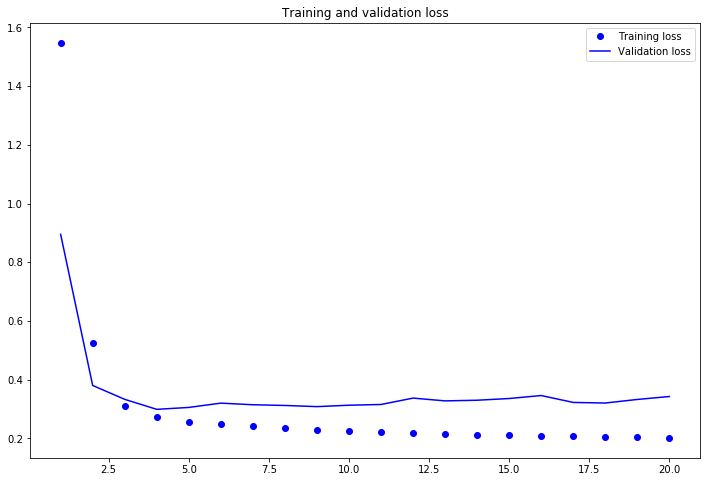

In [31]:
# Plotting the results
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.figure(figsize = (12, 8))
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## GRU Basic Network

In [32]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(units = 32, 
                     input_shape = (None, number_of_features)))
model.add(layers.Dense(units = 1))

model.compile(optimizer = RMSprop(), 
              loss = 'mae')

In [33]:
history = model.fit_generator(train_gen,
                              steps_per_epoch = 500,
                              epochs = 20,
                              validation_data = val_gen,
                              validation_steps = val_steps)

Epoch 1/20


314/500 [=================>............] - ETA: 10:09 - loss: 0.76 - ETA: 6:35 - loss: 0.7343 - ETA: 5:23 - loss: 0.661 - ETA: 4:49 - loss: 0.629 - ETA: 4:26 - loss: 0.606 - ETA: 4:12 - loss: 0.592 - ETA: 4:01 - loss: 0.587 - ETA: 3:53 - loss: 0.574 - ETA: 3:46 - loss: 0.559 - ETA: 3:41 - loss: 0.548 - ETA: 3:37 - loss: 0.541 - ETA: 3:33 - loss: 0.537 - ETA: 3:30 - loss: 0.529 - ETA: 3:27 - loss: 0.519 - ETA: 3:25 - loss: 0.511 - ETA: 3:22 - loss: 0.507 - ETA: 3:21 - loss: 0.500 - ETA: 3:19 - loss: 0.494 - ETA: 3:17 - loss: 0.489 - ETA: 3:16 - loss: 0.482 - ETA: 3:15 - loss: 0.476 - ETA: 3:14 - loss: 0.471 - ETA: 3:12 - loss: 0.466 - ETA: 3:11 - loss: 0.463 - ETA: 3:10 - loss: 0.459 - ETA: 3:09 - loss: 0.455 - ETA: 3:08 - loss: 0.448 - ETA: 3:07 - loss: 0.444 - ETA: 3:07 - loss: 0.442 - ETA: 3:06 - loss: 0.439 - ETA: 3:05 - loss: 0.436 - ETA: 3:04 - loss: 0.434 - ETA: 3:03 - loss: 0.431 - ETA: 3:03 - loss: 0.428 - ETA: 3:02 - loss: 0.424 - ETA: 3:01 - loss: 0.421 - ETA: 3:00 - loss: 0.

500/500 [==============================] - ETA: 1:09 - loss: 0.315 - ETA: 1:08 - loss: 0.315 - ETA: 1:08 - loss: 0.315 - ETA: 1:08 - loss: 0.315 - ETA: 1:07 - loss: 0.315 - ETA: 1:07 - loss: 0.315 - ETA: 1:06 - loss: 0.314 - ETA: 1:06 - loss: 0.314 - ETA: 1:06 - loss: 0.314 - ETA: 1:05 - loss: 0.314 - ETA: 1:05 - loss: 0.314 - ETA: 1:05 - loss: 0.314 - ETA: 1:04 - loss: 0.314 - ETA: 1:04 - loss: 0.314 - ETA: 1:03 - loss: 0.314 - ETA: 1:03 - loss: 0.314 - ETA: 1:03 - loss: 0.314 - ETA: 1:02 - loss: 0.314 - ETA: 1:02 - loss: 0.314 - ETA: 1:02 - loss: 0.314 - ETA: 1:01 - loss: 0.314 - ETA: 1:01 - loss: 0.313 - ETA: 1:00 - loss: 0.313 - ETA: 1:00 - loss: 0.313 - ETA: 1:00 - loss: 0.313 - ETA: 59s - loss: 0.313 - ETA: 59s - loss: 0.31 - ETA: 59s - loss: 0.31 - ETA: 58s - loss: 0.31 - ETA: 58s - loss: 0.31 - ETA: 57s - loss: 0.31 - ETA: 57s - loss: 0.31 - ETA: 57s - loss: 0.31 - ETA: 56s - loss: 0.31 - ETA: 56s - loss: 0.31 - ETA: 56s - loss: 0.31 - ETA: 55s - loss: 0.31 - ETA: 55s - loss: 0

314/500 [=================>............] - ETA: 3:08 - loss: 0.309 - ETA: 3:07 - loss: 0.281 - ETA: 3:06 - loss: 0.289 - ETA: 3:04 - loss: 0.292 - ETA: 3:04 - loss: 0.295 - ETA: 3:03 - loss: 0.291 - ETA: 3:02 - loss: 0.293 - ETA: 3:01 - loss: 0.292 - ETA: 3:01 - loss: 0.291 - ETA: 3:01 - loss: 0.292 - ETA: 3:01 - loss: 0.292 - ETA: 3:00 - loss: 0.294 - ETA: 3:00 - loss: 0.295 - ETA: 2:59 - loss: 0.294 - ETA: 2:59 - loss: 0.295 - ETA: 2:59 - loss: 0.296 - ETA: 2:58 - loss: 0.298 - ETA: 2:58 - loss: 0.298 - ETA: 2:58 - loss: 0.298 - ETA: 2:58 - loss: 0.299 - ETA: 2:57 - loss: 0.298 - ETA: 2:57 - loss: 0.298 - ETA: 2:57 - loss: 0.299 - ETA: 2:56 - loss: 0.299 - ETA: 2:56 - loss: 0.300 - ETA: 2:55 - loss: 0.300 - ETA: 2:55 - loss: 0.300 - ETA: 2:54 - loss: 0.300 - ETA: 2:54 - loss: 0.300 - ETA: 2:54 - loss: 0.298 - ETA: 2:54 - loss: 0.298 - ETA: 2:53 - loss: 0.298 - ETA: 2:53 - loss: 0.298 - ETA: 2:52 - loss: 0.297 - ETA: 2:52 - loss: 0.297 - ETA: 2:52 - loss: 0.297 - ETA: 2:51 - loss: 0.2

500/500 [==============================] - ETA: 1:08 - loss: 0.290 - ETA: 1:08 - loss: 0.290 - ETA: 1:07 - loss: 0.290 - ETA: 1:07 - loss: 0.290 - ETA: 1:07 - loss: 0.290 - ETA: 1:06 - loss: 0.290 - ETA: 1:06 - loss: 0.289 - ETA: 1:05 - loss: 0.289 - ETA: 1:05 - loss: 0.289 - ETA: 1:05 - loss: 0.290 - ETA: 1:04 - loss: 0.289 - ETA: 1:04 - loss: 0.289 - ETA: 1:04 - loss: 0.289 - ETA: 1:03 - loss: 0.289 - ETA: 1:03 - loss: 0.289 - ETA: 1:02 - loss: 0.289 - ETA: 1:02 - loss: 0.289 - ETA: 1:02 - loss: 0.289 - ETA: 1:01 - loss: 0.289 - ETA: 1:01 - loss: 0.289 - ETA: 1:01 - loss: 0.289 - ETA: 1:00 - loss: 0.289 - ETA: 1:00 - loss: 0.289 - ETA: 59s - loss: 0.289 - ETA: 59s - loss: 0.28 - ETA: 59s - loss: 0.28 - ETA: 58s - loss: 0.28 - ETA: 58s - loss: 0.28 - ETA: 58s - loss: 0.28 - ETA: 57s - loss: 0.28 - ETA: 57s - loss: 0.28 - ETA: 57s - loss: 0.28 - ETA: 56s - loss: 0.28 - ETA: 56s - loss: 0.28 - ETA: 55s - loss: 0.28 - ETA: 55s - loss: 0.28 - ETA: 55s - loss: 0.28 - ETA: 54s - loss: 0.28 

314/500 [=================>............] - ETA: 3:00 - loss: 0.276 - ETA: 3:00 - loss: 0.274 - ETA: 3:01 - loss: 0.264 - ETA: 3:02 - loss: 0.273 - ETA: 3:02 - loss: 0.280 - ETA: 3:01 - loss: 0.278 - ETA: 3:01 - loss: 0.280 - ETA: 3:01 - loss: 0.278 - ETA: 3:01 - loss: 0.282 - ETA: 3:00 - loss: 0.281 - ETA: 3:00 - loss: 0.280 - ETA: 2:59 - loss: 0.281 - ETA: 2:59 - loss: 0.278 - ETA: 2:59 - loss: 0.277 - ETA: 2:59 - loss: 0.277 - ETA: 2:58 - loss: 0.276 - ETA: 2:58 - loss: 0.278 - ETA: 2:57 - loss: 0.278 - ETA: 2:57 - loss: 0.277 - ETA: 2:57 - loss: 0.278 - ETA: 2:56 - loss: 0.277 - ETA: 2:56 - loss: 0.277 - ETA: 2:55 - loss: 0.276 - ETA: 2:55 - loss: 0.277 - ETA: 2:55 - loss: 0.277 - ETA: 2:55 - loss: 0.278 - ETA: 2:54 - loss: 0.276 - ETA: 2:54 - loss: 0.277 - ETA: 2:54 - loss: 0.278 - ETA: 2:53 - loss: 0.277 - ETA: 2:53 - loss: 0.276 - ETA: 2:53 - loss: 0.276 - ETA: 2:52 - loss: 0.277 - ETA: 2:52 - loss: 0.277 - ETA: 2:52 - loss: 0.277 - ETA: 2:51 - loss: 0.278 - ETA: 2:51 - loss: 0.2

500/500 [==============================] - ETA: 1:08 - loss: 0.277 - ETA: 1:08 - loss: 0.277 - ETA: 1:08 - loss: 0.277 - ETA: 1:07 - loss: 0.278 - ETA: 1:07 - loss: 0.278 - ETA: 1:07 - loss: 0.277 - ETA: 1:06 - loss: 0.277 - ETA: 1:06 - loss: 0.278 - ETA: 1:05 - loss: 0.278 - ETA: 1:05 - loss: 0.278 - ETA: 1:05 - loss: 0.277 - ETA: 1:04 - loss: 0.277 - ETA: 1:04 - loss: 0.277 - ETA: 1:04 - loss: 0.277 - ETA: 1:03 - loss: 0.277 - ETA: 1:03 - loss: 0.277 - ETA: 1:02 - loss: 0.277 - ETA: 1:02 - loss: 0.277 - ETA: 1:02 - loss: 0.277 - ETA: 1:01 - loss: 0.277 - ETA: 1:01 - loss: 0.277 - ETA: 1:01 - loss: 0.277 - ETA: 1:00 - loss: 0.277 - ETA: 1:00 - loss: 0.277 - ETA: 59s - loss: 0.277 - ETA: 59s - loss: 0.27 - ETA: 59s - loss: 0.27 - ETA: 58s - loss: 0.27 - ETA: 58s - loss: 0.27 - ETA: 58s - loss: 0.27 - ETA: 57s - loss: 0.27 - ETA: 57s - loss: 0.27 - ETA: 56s - loss: 0.27 - ETA: 56s - loss: 0.27 - ETA: 56s - loss: 0.27 - ETA: 55s - loss: 0.27 - ETA: 55s - loss: 0.27 - ETA: 55s - loss: 0.2

314/500 [=================>............] - ETA: 3:04 - loss: 0.308 - ETA: 3:03 - loss: 0.286 - ETA: 3:04 - loss: 0.278 - ETA: 3:03 - loss: 0.288 - ETA: 3:02 - loss: 0.283 - ETA: 3:01 - loss: 0.285 - ETA: 3:01 - loss: 0.285 - ETA: 3:01 - loss: 0.288 - ETA: 3:01 - loss: 0.288 - ETA: 3:00 - loss: 0.287 - ETA: 3:00 - loss: 0.289 - ETA: 3:02 - loss: 0.291 - ETA: 3:06 - loss: 0.288 - ETA: 3:05 - loss: 0.287 - ETA: 3:04 - loss: 0.288 - ETA: 3:03 - loss: 0.285 - ETA: 3:02 - loss: 0.285 - ETA: 3:02 - loss: 0.284 - ETA: 3:01 - loss: 0.284 - ETA: 3:00 - loss: 0.283 - ETA: 3:00 - loss: 0.283 - ETA: 2:59 - loss: 0.281 - ETA: 2:58 - loss: 0.280 - ETA: 2:58 - loss: 0.280 - ETA: 2:58 - loss: 0.278 - ETA: 2:57 - loss: 0.279 - ETA: 2:57 - loss: 0.280 - ETA: 2:56 - loss: 0.280 - ETA: 2:56 - loss: 0.281 - ETA: 2:55 - loss: 0.281 - ETA: 2:55 - loss: 0.281 - ETA: 2:54 - loss: 0.281 - ETA: 2:54 - loss: 0.281 - ETA: 2:53 - loss: 0.280 - ETA: 2:53 - loss: 0.281 - ETA: 2:52 - loss: 0.281 - ETA: 2:52 - loss: 0.2

500/500 [==============================] - ETA: 1:09 - loss: 0.272 - ETA: 1:08 - loss: 0.272 - ETA: 1:08 - loss: 0.272 - ETA: 1:08 - loss: 0.272 - ETA: 1:07 - loss: 0.272 - ETA: 1:07 - loss: 0.272 - ETA: 1:06 - loss: 0.272 - ETA: 1:06 - loss: 0.272 - ETA: 1:06 - loss: 0.272 - ETA: 1:05 - loss: 0.272 - ETA: 1:05 - loss: 0.272 - ETA: 1:05 - loss: 0.272 - ETA: 1:04 - loss: 0.272 - ETA: 1:04 - loss: 0.273 - ETA: 1:03 - loss: 0.272 - ETA: 1:03 - loss: 0.272 - ETA: 1:03 - loss: 0.272 - ETA: 1:02 - loss: 0.272 - ETA: 1:02 - loss: 0.272 - ETA: 1:02 - loss: 0.273 - ETA: 1:01 - loss: 0.273 - ETA: 1:01 - loss: 0.272 - ETA: 1:00 - loss: 0.273 - ETA: 1:00 - loss: 0.273 - ETA: 1:00 - loss: 0.273 - ETA: 59s - loss: 0.273 - ETA: 59s - loss: 0.27 - ETA: 59s - loss: 0.27 - ETA: 58s - loss: 0.27 - ETA: 58s - loss: 0.27 - ETA: 57s - loss: 0.27 - ETA: 57s - loss: 0.27 - ETA: 57s - loss: 0.27 - ETA: 56s - loss: 0.27 - ETA: 56s - loss: 0.27 - ETA: 56s - loss: 0.27 - ETA: 55s - loss: 0.27 - ETA: 55s - loss: 0

314/500 [=================>............] - ETA: 3:11 - loss: 0.301 - ETA: 3:07 - loss: 0.286 - ETA: 3:04 - loss: 0.288 - ETA: 3:04 - loss: 0.288 - ETA: 3:03 - loss: 0.285 - ETA: 3:03 - loss: 0.282 - ETA: 3:02 - loss: 0.279 - ETA: 3:01 - loss: 0.278 - ETA: 3:00 - loss: 0.280 - ETA: 3:00 - loss: 0.279 - ETA: 2:59 - loss: 0.278 - ETA: 2:59 - loss: 0.275 - ETA: 2:59 - loss: 0.274 - ETA: 2:58 - loss: 0.274 - ETA: 2:58 - loss: 0.274 - ETA: 2:58 - loss: 0.275 - ETA: 2:57 - loss: 0.273 - ETA: 2:57 - loss: 0.274 - ETA: 2:56 - loss: 0.276 - ETA: 2:56 - loss: 0.276 - ETA: 2:56 - loss: 0.276 - ETA: 2:56 - loss: 0.276 - ETA: 2:55 - loss: 0.276 - ETA: 2:55 - loss: 0.275 - ETA: 2:55 - loss: 0.274 - ETA: 2:54 - loss: 0.274 - ETA: 2:54 - loss: 0.274 - ETA: 2:54 - loss: 0.274 - ETA: 2:53 - loss: 0.274 - ETA: 2:53 - loss: 0.274 - ETA: 2:53 - loss: 0.274 - ETA: 2:52 - loss: 0.274 - ETA: 2:52 - loss: 0.274 - ETA: 2:51 - loss: 0.273 - ETA: 2:51 - loss: 0.274 - ETA: 2:51 - loss: 0.274 - ETA: 2:50 - loss: 0.2

500/500 [==============================] - ETA: 1:08 - loss: 0.267 - ETA: 1:07 - loss: 0.268 - ETA: 1:07 - loss: 0.268 - ETA: 1:07 - loss: 0.268 - ETA: 1:06 - loss: 0.268 - ETA: 1:06 - loss: 0.268 - ETA: 1:06 - loss: 0.268 - ETA: 1:05 - loss: 0.268 - ETA: 1:05 - loss: 0.268 - ETA: 1:05 - loss: 0.268 - ETA: 1:04 - loss: 0.267 - ETA: 1:04 - loss: 0.267 - ETA: 1:03 - loss: 0.267 - ETA: 1:03 - loss: 0.267 - ETA: 1:03 - loss: 0.267 - ETA: 1:02 - loss: 0.267 - ETA: 1:02 - loss: 0.267 - ETA: 1:02 - loss: 0.268 - ETA: 1:01 - loss: 0.268 - ETA: 1:01 - loss: 0.268 - ETA: 1:01 - loss: 0.267 - ETA: 1:00 - loss: 0.267 - ETA: 1:00 - loss: 0.268 - ETA: 59s - loss: 0.268 - ETA: 59s - loss: 0.26 - ETA: 59s - loss: 0.26 - ETA: 58s - loss: 0.26 - ETA: 58s - loss: 0.26 - ETA: 58s - loss: 0.26 - ETA: 57s - loss: 0.26 - ETA: 57s - loss: 0.26 - ETA: 56s - loss: 0.26 - ETA: 56s - loss: 0.26 - ETA: 56s - loss: 0.26 - ETA: 55s - loss: 0.26 - ETA: 55s - loss: 0.26 - ETA: 55s - loss: 0.26 - ETA: 54s - loss: 0.26 

314/500 [=================>............] - ETA: 3:02 - loss: 0.291 - ETA: 3:02 - loss: 0.288 - ETA: 3:01 - loss: 0.285 - ETA: 3:01 - loss: 0.276 - ETA: 3:02 - loss: 0.275 - ETA: 3:02 - loss: 0.275 - ETA: 3:02 - loss: 0.273 - ETA: 3:01 - loss: 0.272 - ETA: 3:01 - loss: 0.272 - ETA: 3:01 - loss: 0.273 - ETA: 3:00 - loss: 0.272 - ETA: 3:00 - loss: 0.271 - ETA: 3:00 - loss: 0.271 - ETA: 2:59 - loss: 0.270 - ETA: 2:59 - loss: 0.270 - ETA: 2:58 - loss: 0.271 - ETA: 2:58 - loss: 0.270 - ETA: 2:57 - loss: 0.267 - ETA: 2:57 - loss: 0.268 - ETA: 2:57 - loss: 0.269 - ETA: 2:57 - loss: 0.269 - ETA: 2:56 - loss: 0.269 - ETA: 2:56 - loss: 0.268 - ETA: 2:55 - loss: 0.269 - ETA: 2:55 - loss: 0.270 - ETA: 2:54 - loss: 0.270 - ETA: 2:54 - loss: 0.270 - ETA: 2:54 - loss: 0.270 - ETA: 2:53 - loss: 0.269 - ETA: 2:53 - loss: 0.269 - ETA: 2:52 - loss: 0.269 - ETA: 2:52 - loss: 0.268 - ETA: 2:52 - loss: 0.268 - ETA: 2:51 - loss: 0.269 - ETA: 2:51 - loss: 0.269 - ETA: 2:51 - loss: 0.268 - ETA: 2:50 - loss: 0.2

500/500 [==============================] - ETA: 1:08 - loss: 0.265 - ETA: 1:07 - loss: 0.264 - ETA: 1:07 - loss: 0.264 - ETA: 1:07 - loss: 0.264 - ETA: 1:06 - loss: 0.264 - ETA: 1:06 - loss: 0.264 - ETA: 1:06 - loss: 0.264 - ETA: 1:05 - loss: 0.264 - ETA: 1:05 - loss: 0.265 - ETA: 1:04 - loss: 0.265 - ETA: 1:04 - loss: 0.265 - ETA: 1:04 - loss: 0.265 - ETA: 1:03 - loss: 0.265 - ETA: 1:03 - loss: 0.265 - ETA: 1:03 - loss: 0.265 - ETA: 1:02 - loss: 0.265 - ETA: 1:02 - loss: 0.265 - ETA: 1:01 - loss: 0.265 - ETA: 1:01 - loss: 0.265 - ETA: 1:01 - loss: 0.264 - ETA: 1:00 - loss: 0.264 - ETA: 1:00 - loss: 0.264 - ETA: 1:00 - loss: 0.265 - ETA: 59s - loss: 0.265 - ETA: 59s - loss: 0.26 - ETA: 58s - loss: 0.26 - ETA: 58s - loss: 0.26 - ETA: 58s - loss: 0.26 - ETA: 57s - loss: 0.26 - ETA: 57s - loss: 0.26 - ETA: 57s - loss: 0.26 - ETA: 56s - loss: 0.26 - ETA: 56s - loss: 0.26 - ETA: 56s - loss: 0.26 - ETA: 55s - loss: 0.26 - ETA: 55s - loss: 0.26 - ETA: 54s - loss: 0.26 - ETA: 54s - loss: 0.26 

314/500 [=================>............] - ETA: 3:02 - loss: 0.281 - ETA: 3:02 - loss: 0.274 - ETA: 3:01 - loss: 0.268 - ETA: 3:01 - loss: 0.266 - ETA: 3:01 - loss: 0.268 - ETA: 3:01 - loss: 0.263 - ETA: 3:00 - loss: 0.263 - ETA: 3:00 - loss: 0.264 - ETA: 3:00 - loss: 0.259 - ETA: 3:00 - loss: 0.258 - ETA: 3:00 - loss: 0.256 - ETA: 2:59 - loss: 0.256 - ETA: 2:59 - loss: 0.257 - ETA: 2:58 - loss: 0.258 - ETA: 2:58 - loss: 0.255 - ETA: 2:58 - loss: 0.256 - ETA: 2:57 - loss: 0.254 - ETA: 2:57 - loss: 0.256 - ETA: 2:56 - loss: 0.255 - ETA: 2:56 - loss: 0.255 - ETA: 2:56 - loss: 0.253 - ETA: 2:57 - loss: 0.253 - ETA: 2:56 - loss: 0.253 - ETA: 2:56 - loss: 0.253 - ETA: 2:56 - loss: 0.253 - ETA: 2:55 - loss: 0.254 - ETA: 2:55 - loss: 0.255 - ETA: 2:54 - loss: 0.256 - ETA: 2:54 - loss: 0.256 - ETA: 2:54 - loss: 0.256 - ETA: 2:53 - loss: 0.255 - ETA: 2:53 - loss: 0.256 - ETA: 2:52 - loss: 0.257 - ETA: 2:52 - loss: 0.257 - ETA: 2:52 - loss: 0.258 - ETA: 2:51 - loss: 0.257 - ETA: 2:51 - loss: 0.2

500/500 [==============================] - ETA: 1:08 - loss: 0.260 - ETA: 1:08 - loss: 0.260 - ETA: 1:07 - loss: 0.260 - ETA: 1:07 - loss: 0.260 - ETA: 1:06 - loss: 0.260 - ETA: 1:06 - loss: 0.260 - ETA: 1:06 - loss: 0.260 - ETA: 1:05 - loss: 0.260 - ETA: 1:05 - loss: 0.260 - ETA: 1:05 - loss: 0.260 - ETA: 1:04 - loss: 0.260 - ETA: 1:04 - loss: 0.260 - ETA: 1:03 - loss: 0.260 - ETA: 1:03 - loss: 0.260 - ETA: 1:03 - loss: 0.260 - ETA: 1:02 - loss: 0.260 - ETA: 1:02 - loss: 0.260 - ETA: 1:02 - loss: 0.260 - ETA: 1:01 - loss: 0.260 - ETA: 1:01 - loss: 0.260 - ETA: 1:00 - loss: 0.260 - ETA: 1:00 - loss: 0.260 - ETA: 1:00 - loss: 0.260 - ETA: 59s - loss: 0.260 - ETA: 59s - loss: 0.26 - ETA: 59s - loss: 0.26 - ETA: 58s - loss: 0.26 - ETA: 58s - loss: 0.26 - ETA: 58s - loss: 0.26 - ETA: 57s - loss: 0.26 - ETA: 57s - loss: 0.26 - ETA: 56s - loss: 0.26 - ETA: 56s - loss: 0.26 - ETA: 56s - loss: 0.26 - ETA: 55s - loss: 0.26 - ETA: 55s - loss: 0.26 - ETA: 55s - loss: 0.26 - ETA: 54s - loss: 0.26 

314/500 [=================>............] - ETA: 3:16 - loss: 0.242 - ETA: 3:11 - loss: 0.251 - ETA: 3:09 - loss: 0.257 - ETA: 3:07 - loss: 0.252 - ETA: 3:06 - loss: 0.253 - ETA: 3:06 - loss: 0.254 - ETA: 3:05 - loss: 0.256 - ETA: 3:04 - loss: 0.259 - ETA: 3:03 - loss: 0.259 - ETA: 3:03 - loss: 0.263 - ETA: 3:02 - loss: 0.262 - ETA: 3:01 - loss: 0.261 - ETA: 3:01 - loss: 0.262 - ETA: 3:01 - loss: 0.261 - ETA: 3:05 - loss: 0.261 - ETA: 3:09 - loss: 0.259 - ETA: 3:08 - loss: 0.260 - ETA: 3:07 - loss: 0.259 - ETA: 3:07 - loss: 0.259 - ETA: 3:06 - loss: 0.258 - ETA: 3:05 - loss: 0.259 - ETA: 3:04 - loss: 0.258 - ETA: 3:03 - loss: 0.259 - ETA: 3:03 - loss: 0.259 - ETA: 3:02 - loss: 0.258 - ETA: 3:01 - loss: 0.257 - ETA: 3:01 - loss: 0.256 - ETA: 3:00 - loss: 0.258 - ETA: 2:59 - loss: 0.258 - ETA: 2:59 - loss: 0.259 - ETA: 2:58 - loss: 0.258 - ETA: 2:58 - loss: 0.258 - ETA: 2:57 - loss: 0.257 - ETA: 2:57 - loss: 0.257 - ETA: 2:56 - loss: 0.257 - ETA: 2:56 - loss: 0.257 - ETA: 2:55 - loss: 0.2

500/500 [==============================] - ETA: 1:08 - loss: 0.254 - ETA: 1:08 - loss: 0.254 - ETA: 1:08 - loss: 0.254 - ETA: 1:07 - loss: 0.254 - ETA: 1:07 - loss: 0.254 - ETA: 1:06 - loss: 0.254 - ETA: 1:06 - loss: 0.254 - ETA: 1:06 - loss: 0.254 - ETA: 1:05 - loss: 0.254 - ETA: 1:05 - loss: 0.254 - ETA: 1:05 - loss: 0.254 - ETA: 1:04 - loss: 0.254 - ETA: 1:04 - loss: 0.254 - ETA: 1:04 - loss: 0.254 - ETA: 1:03 - loss: 0.254 - ETA: 1:03 - loss: 0.254 - ETA: 1:02 - loss: 0.254 - ETA: 1:02 - loss: 0.254 - ETA: 1:02 - loss: 0.254 - ETA: 1:01 - loss: 0.254 - ETA: 1:01 - loss: 0.254 - ETA: 1:01 - loss: 0.254 - ETA: 1:00 - loss: 0.254 - ETA: 1:00 - loss: 0.254 - ETA: 59s - loss: 0.254 - ETA: 59s - loss: 0.25 - ETA: 59s - loss: 0.25 - ETA: 58s - loss: 0.25 - ETA: 58s - loss: 0.25 - ETA: 58s - loss: 0.25 - ETA: 57s - loss: 0.25 - ETA: 57s - loss: 0.25 - ETA: 56s - loss: 0.25 - ETA: 56s - loss: 0.25 - ETA: 56s - loss: 0.25 - ETA: 55s - loss: 0.25 - ETA: 55s - loss: 0.25 - ETA: 55s - loss: 0.2

314/500 [=================>............] - ETA: 3:04 - loss: 0.268 - ETA: 3:04 - loss: 0.263 - ETA: 3:03 - loss: 0.262 - ETA: 3:04 - loss: 0.260 - ETA: 3:03 - loss: 0.258 - ETA: 3:02 - loss: 0.251 - ETA: 3:01 - loss: 0.251 - ETA: 3:01 - loss: 0.250 - ETA: 3:02 - loss: 0.249 - ETA: 3:01 - loss: 0.250 - ETA: 3:01 - loss: 0.252 - ETA: 3:00 - loss: 0.254 - ETA: 3:00 - loss: 0.253 - ETA: 2:59 - loss: 0.254 - ETA: 2:59 - loss: 0.252 - ETA: 2:59 - loss: 0.250 - ETA: 2:58 - loss: 0.251 - ETA: 2:58 - loss: 0.251 - ETA: 2:58 - loss: 0.252 - ETA: 2:58 - loss: 0.251 - ETA: 2:57 - loss: 0.251 - ETA: 2:57 - loss: 0.251 - ETA: 2:56 - loss: 0.251 - ETA: 2:56 - loss: 0.250 - ETA: 2:56 - loss: 0.251 - ETA: 2:55 - loss: 0.250 - ETA: 2:55 - loss: 0.249 - ETA: 2:54 - loss: 0.249 - ETA: 2:54 - loss: 0.249 - ETA: 2:54 - loss: 0.250 - ETA: 2:53 - loss: 0.250 - ETA: 2:53 - loss: 0.250 - ETA: 2:53 - loss: 0.249 - ETA: 2:52 - loss: 0.250 - ETA: 2:52 - loss: 0.250 - ETA: 2:51 - loss: 0.251 - ETA: 2:51 - loss: 0.2

500/500 [==============================] - ETA: 1:08 - loss: 0.251 - ETA: 1:08 - loss: 0.251 - ETA: 1:08 - loss: 0.251 - ETA: 1:07 - loss: 0.251 - ETA: 1:07 - loss: 0.251 - ETA: 1:06 - loss: 0.251 - ETA: 1:06 - loss: 0.251 - ETA: 1:06 - loss: 0.251 - ETA: 1:05 - loss: 0.251 - ETA: 1:05 - loss: 0.251 - ETA: 1:05 - loss: 0.251 - ETA: 1:04 - loss: 0.251 - ETA: 1:04 - loss: 0.251 - ETA: 1:03 - loss: 0.251 - ETA: 1:03 - loss: 0.251 - ETA: 1:03 - loss: 0.251 - ETA: 1:02 - loss: 0.251 - ETA: 1:02 - loss: 0.251 - ETA: 1:02 - loss: 0.251 - ETA: 1:01 - loss: 0.251 - ETA: 1:01 - loss: 0.251 - ETA: 1:00 - loss: 0.251 - ETA: 1:00 - loss: 0.251 - ETA: 1:00 - loss: 0.251 - ETA: 59s - loss: 0.251 - ETA: 59s - loss: 0.25 - ETA: 59s - loss: 0.25 - ETA: 58s - loss: 0.25 - ETA: 58s - loss: 0.25 - ETA: 57s - loss: 0.25 - ETA: 57s - loss: 0.25 - ETA: 57s - loss: 0.25 - ETA: 56s - loss: 0.25 - ETA: 56s - loss: 0.25 - ETA: 56s - loss: 0.25 - ETA: 55s - loss: 0.25 - ETA: 55s - loss: 0.25 - ETA: 54s - loss: 0.2

314/500 [=================>............] - ETA: 3:06 - loss: 0.255 - ETA: 3:03 - loss: 0.234 - ETA: 3:05 - loss: 0.248 - ETA: 3:04 - loss: 0.247 - ETA: 3:04 - loss: 0.246 - ETA: 3:04 - loss: 0.253 - ETA: 3:03 - loss: 0.252 - ETA: 3:02 - loss: 0.251 - ETA: 3:02 - loss: 0.253 - ETA: 3:01 - loss: 0.250 - ETA: 3:01 - loss: 0.249 - ETA: 3:01 - loss: 0.247 - ETA: 3:00 - loss: 0.248 - ETA: 3:00 - loss: 0.249 - ETA: 2:59 - loss: 0.250 - ETA: 2:59 - loss: 0.251 - ETA: 2:59 - loss: 0.251 - ETA: 2:58 - loss: 0.251 - ETA: 2:58 - loss: 0.251 - ETA: 2:57 - loss: 0.251 - ETA: 2:57 - loss: 0.252 - ETA: 2:57 - loss: 0.251 - ETA: 2:56 - loss: 0.250 - ETA: 2:56 - loss: 0.250 - ETA: 2:55 - loss: 0.251 - ETA: 2:55 - loss: 0.252 - ETA: 2:54 - loss: 0.252 - ETA: 2:54 - loss: 0.253 - ETA: 2:54 - loss: 0.253 - ETA: 2:53 - loss: 0.251 - ETA: 2:53 - loss: 0.250 - ETA: 2:53 - loss: 0.249 - ETA: 2:53 - loss: 0.250 - ETA: 2:52 - loss: 0.249 - ETA: 2:52 - loss: 0.249 - ETA: 2:51 - loss: 0.249 - ETA: 2:51 - loss: 0.2

500/500 [==============================] - ETA: 1:08 - loss: 0.248 - ETA: 1:08 - loss: 0.248 - ETA: 1:07 - loss: 0.248 - ETA: 1:07 - loss: 0.248 - ETA: 1:07 - loss: 0.248 - ETA: 1:06 - loss: 0.248 - ETA: 1:06 - loss: 0.248 - ETA: 1:06 - loss: 0.248 - ETA: 1:05 - loss: 0.248 - ETA: 1:05 - loss: 0.248 - ETA: 1:04 - loss: 0.248 - ETA: 1:04 - loss: 0.248 - ETA: 1:04 - loss: 0.248 - ETA: 1:03 - loss: 0.248 - ETA: 1:03 - loss: 0.248 - ETA: 1:03 - loss: 0.248 - ETA: 1:02 - loss: 0.248 - ETA: 1:02 - loss: 0.248 - ETA: 1:02 - loss: 0.248 - ETA: 1:01 - loss: 0.248 - ETA: 1:01 - loss: 0.248 - ETA: 1:00 - loss: 0.248 - ETA: 1:00 - loss: 0.248 - ETA: 1:00 - loss: 0.248 - ETA: 59s - loss: 0.248 - ETA: 59s - loss: 0.24 - ETA: 59s - loss: 0.24 - ETA: 58s - loss: 0.24 - ETA: 58s - loss: 0.24 - ETA: 57s - loss: 0.24 - ETA: 57s - loss: 0.24 - ETA: 57s - loss: 0.24 - ETA: 56s - loss: 0.24 - ETA: 56s - loss: 0.24 - ETA: 56s - loss: 0.24 - ETA: 55s - loss: 0.24 - ETA: 55s - loss: 0.24 - ETA: 54s - loss: 0.2

314/500 [=================>............] - ETA: 3:04 - loss: 0.252 - ETA: 3:05 - loss: 0.258 - ETA: 3:03 - loss: 0.251 - ETA: 3:03 - loss: 0.254 - ETA: 3:04 - loss: 0.260 - ETA: 3:04 - loss: 0.256 - ETA: 3:04 - loss: 0.257 - ETA: 3:03 - loss: 0.253 - ETA: 3:02 - loss: 0.253 - ETA: 3:02 - loss: 0.253 - ETA: 3:02 - loss: 0.252 - ETA: 3:01 - loss: 0.252 - ETA: 3:01 - loss: 0.249 - ETA: 3:00 - loss: 0.250 - ETA: 3:00 - loss: 0.249 - ETA: 2:59 - loss: 0.250 - ETA: 2:59 - loss: 0.249 - ETA: 2:59 - loss: 0.248 - ETA: 2:58 - loss: 0.248 - ETA: 2:58 - loss: 0.248 - ETA: 2:58 - loss: 0.249 - ETA: 2:58 - loss: 0.250 - ETA: 2:57 - loss: 0.251 - ETA: 2:57 - loss: 0.251 - ETA: 2:57 - loss: 0.250 - ETA: 2:56 - loss: 0.249 - ETA: 2:56 - loss: 0.248 - ETA: 2:55 - loss: 0.248 - ETA: 2:55 - loss: 0.248 - ETA: 2:54 - loss: 0.249 - ETA: 2:54 - loss: 0.250 - ETA: 2:54 - loss: 0.249 - ETA: 2:53 - loss: 0.249 - ETA: 2:53 - loss: 0.248 - ETA: 2:53 - loss: 0.249 - ETA: 2:52 - loss: 0.249 - ETA: 2:52 - loss: 0.2

500/500 [==============================] - ETA: 1:08 - loss: 0.243 - ETA: 1:08 - loss: 0.243 - ETA: 1:07 - loss: 0.243 - ETA: 1:07 - loss: 0.243 - ETA: 1:07 - loss: 0.243 - ETA: 1:06 - loss: 0.243 - ETA: 1:06 - loss: 0.243 - ETA: 1:06 - loss: 0.243 - ETA: 1:05 - loss: 0.243 - ETA: 1:05 - loss: 0.243 - ETA: 1:05 - loss: 0.243 - ETA: 1:04 - loss: 0.243 - ETA: 1:04 - loss: 0.243 - ETA: 1:03 - loss: 0.243 - ETA: 1:03 - loss: 0.243 - ETA: 1:03 - loss: 0.243 - ETA: 1:02 - loss: 0.243 - ETA: 1:02 - loss: 0.243 - ETA: 1:02 - loss: 0.243 - ETA: 1:01 - loss: 0.243 - ETA: 1:01 - loss: 0.243 - ETA: 1:00 - loss: 0.243 - ETA: 1:00 - loss: 0.243 - ETA: 1:00 - loss: 0.243 - ETA: 59s - loss: 0.243 - ETA: 59s - loss: 0.24 - ETA: 59s - loss: 0.24 - ETA: 58s - loss: 0.24 - ETA: 58s - loss: 0.24 - ETA: 57s - loss: 0.24 - ETA: 57s - loss: 0.24 - ETA: 57s - loss: 0.24 - ETA: 56s - loss: 0.24 - ETA: 56s - loss: 0.24 - ETA: 56s - loss: 0.24 - ETA: 55s - loss: 0.24 - ETA: 55s - loss: 0.24 - ETA: 54s - loss: 0.2

314/500 [=================>............] - ETA: 3:07 - loss: 0.254 - ETA: 3:06 - loss: 0.237 - ETA: 3:04 - loss: 0.231 - ETA: 3:02 - loss: 0.231 - ETA: 3:02 - loss: 0.234 - ETA: 3:01 - loss: 0.236 - ETA: 3:02 - loss: 0.236 - ETA: 3:01 - loss: 0.236 - ETA: 3:00 - loss: 0.238 - ETA: 3:00 - loss: 0.241 - ETA: 3:00 - loss: 0.240 - ETA: 2:59 - loss: 0.241 - ETA: 2:59 - loss: 0.240 - ETA: 2:58 - loss: 0.240 - ETA: 2:58 - loss: 0.239 - ETA: 2:57 - loss: 0.239 - ETA: 2:57 - loss: 0.240 - ETA: 2:57 - loss: 0.239 - ETA: 2:57 - loss: 0.240 - ETA: 2:56 - loss: 0.240 - ETA: 2:56 - loss: 0.240 - ETA: 2:55 - loss: 0.239 - ETA: 2:55 - loss: 0.239 - ETA: 2:55 - loss: 0.240 - ETA: 2:54 - loss: 0.240 - ETA: 2:54 - loss: 0.239 - ETA: 2:54 - loss: 0.239 - ETA: 2:53 - loss: 0.240 - ETA: 2:53 - loss: 0.240 - ETA: 2:53 - loss: 0.240 - ETA: 2:53 - loss: 0.240 - ETA: 2:53 - loss: 0.241 - ETA: 2:53 - loss: 0.241 - ETA: 2:52 - loss: 0.241 - ETA: 2:52 - loss: 0.242 - ETA: 2:51 - loss: 0.241 - ETA: 2:51 - loss: 0.2

500/500 [==============================] - ETA: 1:08 - loss: 0.239 - ETA: 1:08 - loss: 0.239 - ETA: 1:07 - loss: 0.239 - ETA: 1:07 - loss: 0.239 - ETA: 1:07 - loss: 0.239 - ETA: 1:06 - loss: 0.239 - ETA: 1:06 - loss: 0.239 - ETA: 1:05 - loss: 0.239 - ETA: 1:05 - loss: 0.239 - ETA: 1:05 - loss: 0.239 - ETA: 1:04 - loss: 0.239 - ETA: 1:04 - loss: 0.239 - ETA: 1:04 - loss: 0.239 - ETA: 1:03 - loss: 0.239 - ETA: 1:03 - loss: 0.239 - ETA: 1:02 - loss: 0.239 - ETA: 1:02 - loss: 0.239 - ETA: 1:02 - loss: 0.239 - ETA: 1:01 - loss: 0.239 - ETA: 1:01 - loss: 0.239 - ETA: 1:01 - loss: 0.239 - ETA: 1:00 - loss: 0.239 - ETA: 1:00 - loss: 0.239 - ETA: 59s - loss: 0.239 - ETA: 59s - loss: 0.23 - ETA: 59s - loss: 0.23 - ETA: 58s - loss: 0.23 - ETA: 58s - loss: 0.23 - ETA: 58s - loss: 0.23 - ETA: 57s - loss: 0.23 - ETA: 57s - loss: 0.23 - ETA: 57s - loss: 0.23 - ETA: 56s - loss: 0.23 - ETA: 56s - loss: 0.23 - ETA: 55s - loss: 0.23 - ETA: 55s - loss: 0.23 - ETA: 55s - loss: 0.23 - ETA: 54s - loss: 0.23 

314/500 [=================>............] - ETA: 3:01 - loss: 0.242 - ETA: 3:01 - loss: 0.242 - ETA: 3:04 - loss: 0.243 - ETA: 3:04 - loss: 0.241 - ETA: 3:04 - loss: 0.241 - ETA: 3:02 - loss: 0.242 - ETA: 3:02 - loss: 0.237 - ETA: 3:01 - loss: 0.237 - ETA: 3:02 - loss: 0.236 - ETA: 3:01 - loss: 0.235 - ETA: 3:01 - loss: 0.235 - ETA: 3:00 - loss: 0.236 - ETA: 3:00 - loss: 0.238 - ETA: 2:59 - loss: 0.239 - ETA: 2:59 - loss: 0.240 - ETA: 2:59 - loss: 0.239 - ETA: 2:58 - loss: 0.240 - ETA: 2:58 - loss: 0.240 - ETA: 2:58 - loss: 0.241 - ETA: 2:57 - loss: 0.240 - ETA: 2:57 - loss: 0.239 - ETA: 2:56 - loss: 0.239 - ETA: 2:56 - loss: 0.238 - ETA: 2:55 - loss: 0.237 - ETA: 2:55 - loss: 0.237 - ETA: 2:55 - loss: 0.236 - ETA: 2:54 - loss: 0.237 - ETA: 2:54 - loss: 0.237 - ETA: 2:53 - loss: 0.238 - ETA: 2:53 - loss: 0.237 - ETA: 2:53 - loss: 0.237 - ETA: 2:53 - loss: 0.237 - ETA: 2:52 - loss: 0.238 - ETA: 2:52 - loss: 0.238 - ETA: 2:51 - loss: 0.238 - ETA: 2:51 - loss: 0.237 - ETA: 2:51 - loss: 0.2

500/500 [==============================] - ETA: 1:08 - loss: 0.234 - ETA: 1:08 - loss: 0.234 - ETA: 1:07 - loss: 0.234 - ETA: 1:07 - loss: 0.234 - ETA: 1:07 - loss: 0.234 - ETA: 1:06 - loss: 0.234 - ETA: 1:06 - loss: 0.234 - ETA: 1:06 - loss: 0.234 - ETA: 1:05 - loss: 0.234 - ETA: 1:05 - loss: 0.234 - ETA: 1:04 - loss: 0.234 - ETA: 1:04 - loss: 0.234 - ETA: 1:04 - loss: 0.234 - ETA: 1:03 - loss: 0.234 - ETA: 1:03 - loss: 0.234 - ETA: 1:03 - loss: 0.234 - ETA: 1:02 - loss: 0.234 - ETA: 1:02 - loss: 0.234 - ETA: 1:02 - loss: 0.234 - ETA: 1:01 - loss: 0.234 - ETA: 1:01 - loss: 0.234 - ETA: 1:00 - loss: 0.234 - ETA: 1:00 - loss: 0.234 - ETA: 1:00 - loss: 0.234 - ETA: 59s - loss: 0.234 - ETA: 59s - loss: 0.23 - ETA: 59s - loss: 0.23 - ETA: 58s - loss: 0.23 - ETA: 58s - loss: 0.23 - ETA: 57s - loss: 0.23 - ETA: 57s - loss: 0.23 - ETA: 57s - loss: 0.23 - ETA: 56s - loss: 0.23 - ETA: 56s - loss: 0.23 - ETA: 56s - loss: 0.23 - ETA: 55s - loss: 0.23 - ETA: 55s - loss: 0.23 - ETA: 54s - loss: 0.2

314/500 [=================>............] - ETA: 3:04 - loss: 0.196 - ETA: 3:03 - loss: 0.222 - ETA: 3:03 - loss: 0.225 - ETA: 3:02 - loss: 0.231 - ETA: 3:02 - loss: 0.231 - ETA: 3:03 - loss: 0.235 - ETA: 3:02 - loss: 0.234 - ETA: 3:02 - loss: 0.233 - ETA: 3:02 - loss: 0.230 - ETA: 3:02 - loss: 0.228 - ETA: 3:01 - loss: 0.230 - ETA: 3:01 - loss: 0.229 - ETA: 3:00 - loss: 0.229 - ETA: 3:00 - loss: 0.230 - ETA: 2:59 - loss: 0.231 - ETA: 2:59 - loss: 0.233 - ETA: 2:59 - loss: 0.233 - ETA: 2:58 - loss: 0.233 - ETA: 2:58 - loss: 0.232 - ETA: 2:58 - loss: 0.230 - ETA: 2:58 - loss: 0.229 - ETA: 2:57 - loss: 0.229 - ETA: 2:57 - loss: 0.231 - ETA: 2:57 - loss: 0.231 - ETA: 2:56 - loss: 0.232 - ETA: 2:56 - loss: 0.231 - ETA: 2:55 - loss: 0.232 - ETA: 2:55 - loss: 0.232 - ETA: 2:55 - loss: 0.231 - ETA: 2:54 - loss: 0.232 - ETA: 2:54 - loss: 0.231 - ETA: 2:54 - loss: 0.231 - ETA: 2:53 - loss: 0.232 - ETA: 2:53 - loss: 0.231 - ETA: 2:53 - loss: 0.231 - ETA: 2:52 - loss: 0.232 - ETA: 2:52 - loss: 0.2

500/500 [==============================] - ETA: 1:08 - loss: 0.232 - ETA: 1:08 - loss: 0.232 - ETA: 1:08 - loss: 0.232 - ETA: 1:07 - loss: 0.232 - ETA: 1:07 - loss: 0.232 - ETA: 1:07 - loss: 0.232 - ETA: 1:06 - loss: 0.232 - ETA: 1:06 - loss: 0.232 - ETA: 1:06 - loss: 0.232 - ETA: 1:05 - loss: 0.232 - ETA: 1:05 - loss: 0.232 - ETA: 1:04 - loss: 0.232 - ETA: 1:04 - loss: 0.232 - ETA: 1:04 - loss: 0.232 - ETA: 1:03 - loss: 0.232 - ETA: 1:03 - loss: 0.232 - ETA: 1:03 - loss: 0.232 - ETA: 1:02 - loss: 0.232 - ETA: 1:02 - loss: 0.232 - ETA: 1:01 - loss: 0.232 - ETA: 1:01 - loss: 0.232 - ETA: 1:01 - loss: 0.232 - ETA: 1:00 - loss: 0.232 - ETA: 1:00 - loss: 0.232 - ETA: 1:00 - loss: 0.232 - ETA: 59s - loss: 0.232 - ETA: 59s - loss: 0.23 - ETA: 58s - loss: 0.23 - ETA: 58s - loss: 0.23 - ETA: 58s - loss: 0.23 - ETA: 57s - loss: 0.23 - ETA: 57s - loss: 0.23 - ETA: 57s - loss: 0.23 - ETA: 56s - loss: 0.23 - ETA: 56s - loss: 0.23 - ETA: 55s - loss: 0.23 - ETA: 55s - loss: 0.23 - ETA: 55s - loss: 0

314/500 [=================>............] - ETA: 3:02 - loss: 0.228 - ETA: 3:02 - loss: 0.226 - ETA: 3:02 - loss: 0.230 - ETA: 3:01 - loss: 0.230 - ETA: 3:02 - loss: 0.229 - ETA: 3:02 - loss: 0.225 - ETA: 3:02 - loss: 0.224 - ETA: 3:02 - loss: 0.226 - ETA: 3:01 - loss: 0.220 - ETA: 3:01 - loss: 0.219 - ETA: 3:00 - loss: 0.220 - ETA: 3:00 - loss: 0.222 - ETA: 2:59 - loss: 0.223 - ETA: 2:59 - loss: 0.224 - ETA: 2:59 - loss: 0.226 - ETA: 2:58 - loss: 0.225 - ETA: 2:58 - loss: 0.225 - ETA: 2:57 - loss: 0.225 - ETA: 2:57 - loss: 0.225 - ETA: 2:57 - loss: 0.226 - ETA: 2:57 - loss: 0.227 - ETA: 2:56 - loss: 0.228 - ETA: 2:56 - loss: 0.228 - ETA: 2:55 - loss: 0.229 - ETA: 2:55 - loss: 0.229 - ETA: 2:55 - loss: 0.229 - ETA: 2:54 - loss: 0.229 - ETA: 2:54 - loss: 0.230 - ETA: 2:53 - loss: 0.231 - ETA: 2:53 - loss: 0.231 - ETA: 2:53 - loss: 0.231 - ETA: 2:53 - loss: 0.232 - ETA: 2:52 - loss: 0.232 - ETA: 2:52 - loss: 0.231 - ETA: 2:52 - loss: 0.231 - ETA: 2:51 - loss: 0.231 - ETA: 2:51 - loss: 0.2

500/500 [==============================] - ETA: 1:08 - loss: 0.227 - ETA: 1:08 - loss: 0.227 - ETA: 1:08 - loss: 0.227 - ETA: 1:07 - loss: 0.227 - ETA: 1:07 - loss: 0.227 - ETA: 1:06 - loss: 0.228 - ETA: 1:06 - loss: 0.228 - ETA: 1:06 - loss: 0.228 - ETA: 1:05 - loss: 0.228 - ETA: 1:05 - loss: 0.228 - ETA: 1:05 - loss: 0.228 - ETA: 1:04 - loss: 0.228 - ETA: 1:04 - loss: 0.228 - ETA: 1:03 - loss: 0.228 - ETA: 1:03 - loss: 0.228 - ETA: 1:03 - loss: 0.228 - ETA: 1:02 - loss: 0.227 - ETA: 1:02 - loss: 0.227 - ETA: 1:02 - loss: 0.227 - ETA: 1:01 - loss: 0.227 - ETA: 1:01 - loss: 0.227 - ETA: 1:00 - loss: 0.227 - ETA: 1:00 - loss: 0.227 - ETA: 1:00 - loss: 0.227 - ETA: 59s - loss: 0.227 - ETA: 59s - loss: 0.22 - ETA: 59s - loss: 0.22 - ETA: 58s - loss: 0.22 - ETA: 58s - loss: 0.22 - ETA: 57s - loss: 0.22 - ETA: 57s - loss: 0.22 - ETA: 57s - loss: 0.22 - ETA: 56s - loss: 0.22 - ETA: 56s - loss: 0.22 - ETA: 56s - loss: 0.22 - ETA: 55s - loss: 0.22 - ETA: 55s - loss: 0.22 - ETA: 54s - loss: 0.2

314/500 [=================>............] - ETA: 3:08 - loss: 0.241 - ETA: 3:07 - loss: 0.229 - ETA: 3:05 - loss: 0.228 - ETA: 3:05 - loss: 0.222 - ETA: 3:03 - loss: 0.222 - ETA: 3:03 - loss: 0.221 - ETA: 3:03 - loss: 0.224 - ETA: 3:02 - loss: 0.225 - ETA: 3:02 - loss: 0.227 - ETA: 3:01 - loss: 0.230 - ETA: 3:01 - loss: 0.228 - ETA: 3:01 - loss: 0.227 - ETA: 3:01 - loss: 0.228 - ETA: 3:00 - loss: 0.226 - ETA: 2:59 - loss: 0.225 - ETA: 2:59 - loss: 0.225 - ETA: 2:59 - loss: 0.225 - ETA: 2:59 - loss: 0.225 - ETA: 2:58 - loss: 0.225 - ETA: 2:58 - loss: 0.225 - ETA: 2:57 - loss: 0.227 - ETA: 2:57 - loss: 0.225 - ETA: 2:57 - loss: 0.225 - ETA: 2:57 - loss: 0.226 - ETA: 2:56 - loss: 0.225 - ETA: 2:56 - loss: 0.226 - ETA: 2:56 - loss: 0.225 - ETA: 2:55 - loss: 0.225 - ETA: 2:55 - loss: 0.225 - ETA: 2:54 - loss: 0.225 - ETA: 2:54 - loss: 0.224 - ETA: 2:54 - loss: 0.224 - ETA: 2:53 - loss: 0.224 - ETA: 2:53 - loss: 0.224 - ETA: 2:53 - loss: 0.224 - ETA: 2:52 - loss: 0.223 - ETA: 2:52 - loss: 0.2

500/500 [==============================] - ETA: 1:08 - loss: 0.223 - ETA: 1:08 - loss: 0.223 - ETA: 1:08 - loss: 0.223 - ETA: 1:07 - loss: 0.223 - ETA: 1:07 - loss: 0.223 - ETA: 1:07 - loss: 0.223 - ETA: 1:06 - loss: 0.223 - ETA: 1:06 - loss: 0.223 - ETA: 1:05 - loss: 0.223 - ETA: 1:05 - loss: 0.223 - ETA: 1:05 - loss: 0.223 - ETA: 1:04 - loss: 0.223 - ETA: 1:04 - loss: 0.223 - ETA: 1:04 - loss: 0.223 - ETA: 1:03 - loss: 0.223 - ETA: 1:03 - loss: 0.223 - ETA: 1:02 - loss: 0.223 - ETA: 1:02 - loss: 0.223 - ETA: 1:02 - loss: 0.223 - ETA: 1:01 - loss: 0.223 - ETA: 1:01 - loss: 0.223 - ETA: 1:01 - loss: 0.223 - ETA: 1:00 - loss: 0.223 - ETA: 1:00 - loss: 0.223 - ETA: 59s - loss: 0.223 - ETA: 59s - loss: 0.22 - ETA: 59s - loss: 0.22 - ETA: 58s - loss: 0.22 - ETA: 58s - loss: 0.22 - ETA: 58s - loss: 0.22 - ETA: 57s - loss: 0.22 - ETA: 57s - loss: 0.22 - ETA: 56s - loss: 0.22 - ETA: 56s - loss: 0.22 - ETA: 56s - loss: 0.22 - ETA: 55s - loss: 0.22 - ETA: 55s - loss: 0.22 - ETA: 55s - loss: 0.2

314/500 [=================>............] - ETA: 3:06 - loss: 0.229 - ETA: 3:04 - loss: 0.225 - ETA: 3:03 - loss: 0.224 - ETA: 3:02 - loss: 0.225 - ETA: 3:03 - loss: 0.228 - ETA: 3:03 - loss: 0.224 - ETA: 3:03 - loss: 0.223 - ETA: 3:03 - loss: 0.219 - ETA: 3:02 - loss: 0.219 - ETA: 3:02 - loss: 0.221 - ETA: 3:02 - loss: 0.224 - ETA: 3:01 - loss: 0.224 - ETA: 3:01 - loss: 0.222 - ETA: 3:01 - loss: 0.222 - ETA: 3:00 - loss: 0.223 - ETA: 3:00 - loss: 0.223 - ETA: 2:59 - loss: 0.224 - ETA: 2:59 - loss: 0.223 - ETA: 2:58 - loss: 0.223 - ETA: 2:58 - loss: 0.222 - ETA: 2:57 - loss: 0.222 - ETA: 2:57 - loss: 0.221 - ETA: 2:57 - loss: 0.221 - ETA: 2:56 - loss: 0.221 - ETA: 2:56 - loss: 0.221 - ETA: 2:55 - loss: 0.220 - ETA: 2:55 - loss: 0.220 - ETA: 2:55 - loss: 0.220 - ETA: 2:54 - loss: 0.221 - ETA: 2:54 - loss: 0.221 - ETA: 2:54 - loss: 0.221 - ETA: 2:53 - loss: 0.223 - ETA: 2:53 - loss: 0.224 - ETA: 2:52 - loss: 0.223 - ETA: 2:52 - loss: 0.223 - ETA: 2:52 - loss: 0.223 - ETA: 2:51 - loss: 0.2

500/500 [==============================] - ETA: 1:08 - loss: 0.222 - ETA: 1:08 - loss: 0.222 - ETA: 1:08 - loss: 0.222 - ETA: 1:07 - loss: 0.222 - ETA: 1:07 - loss: 0.222 - ETA: 1:06 - loss: 0.222 - ETA: 1:06 - loss: 0.222 - ETA: 1:06 - loss: 0.222 - ETA: 1:05 - loss: 0.222 - ETA: 1:05 - loss: 0.222 - ETA: 1:05 - loss: 0.222 - ETA: 1:04 - loss: 0.222 - ETA: 1:04 - loss: 0.222 - ETA: 1:03 - loss: 0.222 - ETA: 1:03 - loss: 0.222 - ETA: 1:03 - loss: 0.222 - ETA: 1:02 - loss: 0.222 - ETA: 1:02 - loss: 0.222 - ETA: 1:02 - loss: 0.222 - ETA: 1:01 - loss: 0.222 - ETA: 1:01 - loss: 0.222 - ETA: 1:01 - loss: 0.222 - ETA: 1:00 - loss: 0.222 - ETA: 1:00 - loss: 0.222 - ETA: 59s - loss: 0.222 - ETA: 59s - loss: 0.22 - ETA: 59s - loss: 0.22 - ETA: 58s - loss: 0.22 - ETA: 58s - loss: 0.22 - ETA: 58s - loss: 0.22 - ETA: 57s - loss: 0.22 - ETA: 57s - loss: 0.22 - ETA: 56s - loss: 0.22 - ETA: 56s - loss: 0.22 - ETA: 56s - loss: 0.22 - ETA: 55s - loss: 0.22 - ETA: 55s - loss: 0.22 - ETA: 55s - loss: 0.2

314/500 [=================>............] - ETA: 3:07 - loss: 0.227 - ETA: 3:04 - loss: 0.212 - ETA: 3:04 - loss: 0.223 - ETA: 3:04 - loss: 0.221 - ETA: 3:04 - loss: 0.221 - ETA: 3:04 - loss: 0.219 - ETA: 3:03 - loss: 0.216 - ETA: 3:02 - loss: 0.216 - ETA: 3:01 - loss: 0.217 - ETA: 3:01 - loss: 0.217 - ETA: 3:01 - loss: 0.215 - ETA: 3:01 - loss: 0.216 - ETA: 3:00 - loss: 0.215 - ETA: 3:00 - loss: 0.214 - ETA: 2:59 - loss: 0.216 - ETA: 2:59 - loss: 0.217 - ETA: 2:59 - loss: 0.216 - ETA: 2:58 - loss: 0.217 - ETA: 2:58 - loss: 0.220 - ETA: 2:57 - loss: 0.220 - ETA: 2:57 - loss: 0.220 - ETA: 2:57 - loss: 0.221 - ETA: 2:57 - loss: 0.221 - ETA: 2:56 - loss: 0.221 - ETA: 2:55 - loss: 0.222 - ETA: 2:55 - loss: 0.223 - ETA: 2:55 - loss: 0.224 - ETA: 2:54 - loss: 0.223 - ETA: 2:54 - loss: 0.222 - ETA: 2:54 - loss: 0.223 - ETA: 2:53 - loss: 0.222 - ETA: 2:53 - loss: 0.222 - ETA: 2:52 - loss: 0.222 - ETA: 2:52 - loss: 0.222 - ETA: 2:52 - loss: 0.222 - ETA: 2:51 - loss: 0.222 - ETA: 2:51 - loss: 0.2

500/500 [==============================] - ETA: 1:08 - loss: 0.219 - ETA: 1:08 - loss: 0.219 - ETA: 1:07 - loss: 0.219 - ETA: 1:07 - loss: 0.219 - ETA: 1:07 - loss: 0.219 - ETA: 1:06 - loss: 0.219 - ETA: 1:06 - loss: 0.219 - ETA: 1:06 - loss: 0.219 - ETA: 1:05 - loss: 0.219 - ETA: 1:05 - loss: 0.219 - ETA: 1:04 - loss: 0.219 - ETA: 1:04 - loss: 0.220 - ETA: 1:04 - loss: 0.219 - ETA: 1:03 - loss: 0.219 - ETA: 1:03 - loss: 0.219 - ETA: 1:03 - loss: 0.220 - ETA: 1:02 - loss: 0.220 - ETA: 1:02 - loss: 0.219 - ETA: 1:02 - loss: 0.220 - ETA: 1:01 - loss: 0.219 - ETA: 1:01 - loss: 0.219 - ETA: 1:00 - loss: 0.219 - ETA: 1:00 - loss: 0.219 - ETA: 1:00 - loss: 0.220 - ETA: 59s - loss: 0.220 - ETA: 59s - loss: 0.22 - ETA: 59s - loss: 0.22 - ETA: 58s - loss: 0.22 - ETA: 58s - loss: 0.21 - ETA: 57s - loss: 0.22 - ETA: 57s - loss: 0.21 - ETA: 57s - loss: 0.21 - ETA: 56s - loss: 0.21 - ETA: 56s - loss: 0.21 - ETA: 56s - loss: 0.21 - ETA: 55s - loss: 0.21 - ETA: 55s - loss: 0.21 - ETA: 54s - loss: 0.2

314/500 [=================>............] - ETA: 2:59 - loss: 0.211 - ETA: 3:02 - loss: 0.224 - ETA: 3:02 - loss: 0.210 - ETA: 3:01 - loss: 0.214 - ETA: 3:01 - loss: 0.214 - ETA: 3:01 - loss: 0.215 - ETA: 3:01 - loss: 0.216 - ETA: 3:01 - loss: 0.216 - ETA: 3:01 - loss: 0.217 - ETA: 3:00 - loss: 0.215 - ETA: 3:00 - loss: 0.217 - ETA: 3:00 - loss: 0.218 - ETA: 3:00 - loss: 0.219 - ETA: 3:00 - loss: 0.221 - ETA: 2:59 - loss: 0.219 - ETA: 2:59 - loss: 0.219 - ETA: 2:58 - loss: 0.220 - ETA: 2:58 - loss: 0.221 - ETA: 2:58 - loss: 0.220 - ETA: 2:57 - loss: 0.219 - ETA: 2:57 - loss: 0.219 - ETA: 2:56 - loss: 0.219 - ETA: 2:56 - loss: 0.219 - ETA: 2:55 - loss: 0.219 - ETA: 2:55 - loss: 0.219 - ETA: 2:55 - loss: 0.218 - ETA: 2:54 - loss: 0.219 - ETA: 2:54 - loss: 0.219 - ETA: 2:55 - loss: 0.219 - ETA: 2:54 - loss: 0.219 - ETA: 2:54 - loss: 0.220 - ETA: 2:53 - loss: 0.220 - ETA: 2:53 - loss: 0.219 - ETA: 2:53 - loss: 0.218 - ETA: 2:52 - loss: 0.218 - ETA: 2:52 - loss: 0.218 - ETA: 2:52 - loss: 0.2

500/500 [==============================] - ETA: 1:08 - loss: 0.217 - ETA: 1:08 - loss: 0.217 - ETA: 1:07 - loss: 0.217 - ETA: 1:07 - loss: 0.217 - ETA: 1:07 - loss: 0.217 - ETA: 1:06 - loss: 0.217 - ETA: 1:06 - loss: 0.217 - ETA: 1:05 - loss: 0.217 - ETA: 1:05 - loss: 0.217 - ETA: 1:05 - loss: 0.217 - ETA: 1:04 - loss: 0.217 - ETA: 1:04 - loss: 0.217 - ETA: 1:04 - loss: 0.217 - ETA: 1:03 - loss: 0.217 - ETA: 1:03 - loss: 0.217 - ETA: 1:03 - loss: 0.217 - ETA: 1:02 - loss: 0.217 - ETA: 1:02 - loss: 0.217 - ETA: 1:01 - loss: 0.217 - ETA: 1:01 - loss: 0.217 - ETA: 1:01 - loss: 0.217 - ETA: 1:00 - loss: 0.217 - ETA: 1:00 - loss: 0.217 - ETA: 1:00 - loss: 0.217 - ETA: 59s - loss: 0.217 - ETA: 59s - loss: 0.21 - ETA: 58s - loss: 0.21 - ETA: 58s - loss: 0.21 - ETA: 58s - loss: 0.21 - ETA: 57s - loss: 0.21 - ETA: 57s - loss: 0.21 - ETA: 57s - loss: 0.21 - ETA: 56s - loss: 0.21 - ETA: 56s - loss: 0.21 - ETA: 55s - loss: 0.21 - ETA: 55s - loss: 0.21 - ETA: 55s - loss: 0.21 - ETA: 54s - loss: 0.2

314/500 [=================>............] - ETA: 3:00 - loss: 0.185 - ETA: 3:01 - loss: 0.195 - ETA: 3:08 - loss: 0.201 - ETA: 3:13 - loss: 0.203 - ETA: 3:11 - loss: 0.205 - ETA: 3:08 - loss: 0.213 - ETA: 3:07 - loss: 0.214 - ETA: 3:07 - loss: 0.210 - ETA: 3:07 - loss: 0.211 - ETA: 3:06 - loss: 0.215 - ETA: 3:05 - loss: 0.215 - ETA: 3:04 - loss: 0.217 - ETA: 3:04 - loss: 0.214 - ETA: 3:03 - loss: 0.215 - ETA: 3:03 - loss: 0.214 - ETA: 3:03 - loss: 0.212 - ETA: 3:02 - loss: 0.212 - ETA: 3:02 - loss: 0.213 - ETA: 3:01 - loss: 0.213 - ETA: 3:01 - loss: 0.213 - ETA: 3:00 - loss: 0.213 - ETA: 3:00 - loss: 0.214 - ETA: 2:59 - loss: 0.212 - ETA: 2:59 - loss: 0.212 - ETA: 2:58 - loss: 0.212 - ETA: 2:58 - loss: 0.212 - ETA: 2:57 - loss: 0.211 - ETA: 2:57 - loss: 0.212 - ETA: 2:56 - loss: 0.212 - ETA: 2:56 - loss: 0.212 - ETA: 2:56 - loss: 0.212 - ETA: 2:55 - loss: 0.213 - ETA: 2:55 - loss: 0.213 - ETA: 2:54 - loss: 0.213 - ETA: 2:54 - loss: 0.213 - ETA: 2:53 - loss: 0.214 - ETA: 2:53 - loss: 0.2

500/500 [==============================] - ETA: 1:09 - loss: 0.214 - ETA: 1:08 - loss: 0.214 - ETA: 1:08 - loss: 0.214 - ETA: 1:07 - loss: 0.215 - ETA: 1:07 - loss: 0.214 - ETA: 1:07 - loss: 0.214 - ETA: 1:06 - loss: 0.214 - ETA: 1:06 - loss: 0.214 - ETA: 1:06 - loss: 0.214 - ETA: 1:05 - loss: 0.214 - ETA: 1:05 - loss: 0.214 - ETA: 1:04 - loss: 0.214 - ETA: 1:04 - loss: 0.214 - ETA: 1:04 - loss: 0.214 - ETA: 1:03 - loss: 0.214 - ETA: 1:03 - loss: 0.214 - ETA: 1:03 - loss: 0.214 - ETA: 1:02 - loss: 0.214 - ETA: 1:02 - loss: 0.214 - ETA: 1:01 - loss: 0.214 - ETA: 1:01 - loss: 0.214 - ETA: 1:01 - loss: 0.214 - ETA: 1:00 - loss: 0.214 - ETA: 1:00 - loss: 0.214 - ETA: 1:00 - loss: 0.214 - ETA: 59s - loss: 0.214 - ETA: 59s - loss: 0.21 - ETA: 58s - loss: 0.21 - ETA: 58s - loss: 0.21 - ETA: 58s - loss: 0.21 - ETA: 57s - loss: 0.21 - ETA: 57s - loss: 0.21 - ETA: 57s - loss: 0.21 - ETA: 56s - loss: 0.21 - ETA: 56s - loss: 0.21 - ETA: 55s - loss: 0.21 - ETA: 55s - loss: 0.21 - ETA: 55s - loss: 0

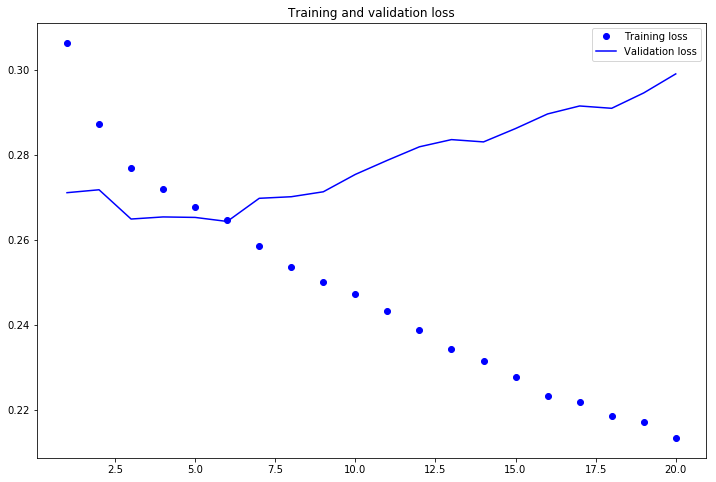

In [34]:
# Plotting the results
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.figure(figsize = (12, 8))
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## GRU Basic Network with Dropout

In [36]:
from keras.layers import GRU

In [37]:
model = Sequential()
model.add(GRU(units = 32,
              dropout = 0.2,
              recurrent_dropout = 0.2,
              input_shape = (None, number_of_features)))
model.add(Dense(units = 1))
model.compile(optimizer=RMSprop(), loss = 'mae')

In [ ]:
history = model.fit_generator(generator = train_gen,
                              steps_per_epoch = 500,
                              epochs = 40,
                              validation_data = val_gen,
                              validation_steps = val_steps)

In [ ]:
# Plotting the results
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.figure(figsize = (12, 8))
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Stacking recurrent layers

In [ ]:
model = Sequential()
model.add(GRU(units = 32,
              dropout = 0.1,
              recurrent_dropout = 0.5,
              return_sequences = True,
              input_shape = (None, number_of_features)))
model.add(GRU(units = 64, 
              activation = 'relu',
              dropout = 0.1, 
              recurrent_dropout = 0.5))
model.add(Dense(units = 1))
model.compile(optimizer = RMSprop(), 
              loss = 'mae')

In [ ]:
history = model.fit_generator(train_gen,
                              steps_per_epoch = 500,
                              epochs = 40,
                              validation_data = val_gen,
                              validation_steps = val_steps)

In [ ]:
# Plotting the results
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.figure(figsize = (12, 8))
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Bidirectional RNNs

In [ ]:
# To be continued.